# **EPIC 4 - MODELING**

![modeling](../docs/images/modeling.png)

## Objectives

- Train and validate the model on the prepared image datasets.

### Acceptance Criteria
- Image sets should initially be 70% training, 15% validation, and 15% test.
- Model performs 'well' on validation set - otherwise, return to Pre-process images #4

## Tasks
- Split the images into training, validation, and test sets.
- Plot the numbers of images in each set (LO 3.1).

## Inputs

- Labelled folders containing the resized images for each breed.

## Outputs

- Model which returns the top 3 predictions for a given image, based on accuracy values.

---

# Import packages

In [99]:
import os
import joblib
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf

from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Input, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Set working directory

In [100]:
current_dir = os.getcwd()
print("Current working directory is:", current_dir)

Current working directory is: /Users/gingermale/Documents/repos/pet-image-classifier


**If required**, run following cell to move to the parent / project root directory.

In [4]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print("Changing the working directory to parent folder:", current_dir)

Changing the working directory to parent folder: /Users/gingermale/Documents/repos/pet-image-classifier


# Set input and output paths

In [129]:
inputs_dir = current_dir + '/inputs'
train_dir = inputs_dir + '/train'
validate_dir = inputs_dir + '/validate'
test_dir = inputs_dir + '/test'

version = 'v4'
outputs = f'outputs/{version}'

if os.path.exists(outputs):
    print(f'Output directory for {version} already exists.')
else:
    os.makedirs(outputs)
    print(f'New output directory for {version} created.')

Output directory for v4 already exists.


# Split the images

First, we define the function to split the images into training, validation, and test sets.

In [7]:
import shutil
import random
import joblib

def split_train_validate_test_images(data_dir, train_set_ratio, validate_set_ratio, test_set_ratio):
    """
    split data set into three groups by ratios specified
    """
    if train_set_ratio + validate_set_ratio + test_set_ratio != 1.0:
        print("train_set_ratio + validate_set_ratio + test_set_ratio should sum to 1.0")
        return

    # gets classes labels
    labels = os.listdir(data_dir)  # it should get only the folder name
    labels = [label for label in labels if label != '.DS_Store']  # Ignore .DS_Store files

    if 'test' in labels:
        pass
    else:
        # create train, test folders with classes labels sub-folder
        for folder in ['train', 'validate', 'test']:
            for label in labels:
                if folder == 'train':
                    os.makedirs(name=train_dir + '/' + label, exist_ok=True)
                elif folder == 'validate':
                    os.makedirs(name=validate_dir + '/' + label, exist_ok=True)
                else:  # folder == 'test'
                    os.makedirs(name=test_dir + '/' + label, exist_ok=True)

        for label in labels:

            files = os.listdir(data_dir + '/' + label)
            random.shuffle(files)

            train_set_files_qty = int(len(files) * train_set_ratio)
            validate_set_files_qty = int(len(files) * validate_set_ratio)

            # Move files to appropriate set directories
            # Use of enumerate leads to improved memory efficiency and faster execution time,
            # particularly in cases where the loop is iterating over a large number of items.
            for count, file_name in enumerate(files):
                if count < train_set_files_qty:
                    # move a given file to the train set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                train_dir + '/' + label + '/' + file_name)

                elif count < (train_set_files_qty + validate_set_files_qty):
                    # move a given file to the validation set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                validate_dir + '/' + label + '/' + file_name)

                else:
                    # move given file to test set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                test_dir + '/' + label + '/' + file_name)

            os.rmdir(data_dir + '/' + label)

Then we run the function, specifying the ratios by which to split the images. We use 70% for training, 15% for validation, and 15% for testing as a reasonable starting point.

In [8]:
split_train_validate_test_images(data_dir,
                        train_set_ratio = 0.7,
                        validate_set_ratio=0.15,
                        test_set_ratio=0.15
                        )

# Number of images in each set (LO 3.1)

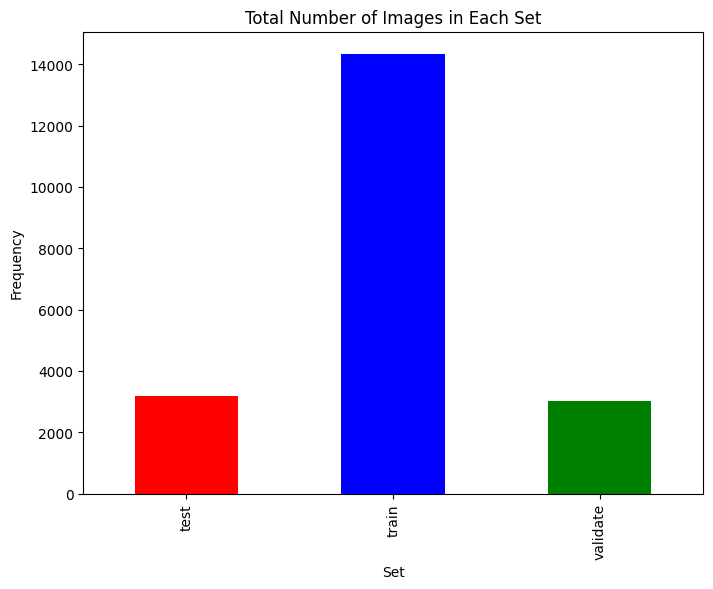

In [102]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Define directories
directories = {
    'train': train_dir,
    'validate': validate_dir,
    'test': test_dir
}

for folder, dir_path in directories.items():
    labels_dir = [f for f in os.listdir(dir_path) if not f.startswith('.')]
    for label in labels_dir:
        files = [f for f in os.listdir(os.path.join(dir_path, label)) if not f.startswith('.')]
        count = len(files)
        df_to_append = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': count}], columns=['Set', 'Label', 'Frequency'])
        df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

# Summarize data
df_summary = df_freq.groupby('Set')['Frequency'].sum().reset_index()

# Plotting
df_summary.plot(x='Set', y='Frequency', kind='bar', legend=False, color=['red', 'blue', 'green'], figsize=(8, 6))
plt.ylabel('Frequency')
plt.title('Total Number of Images in Each Set')
plt.show()

In [7]:
# Initialize an empty DataFrame
df_freq = pd.DataFrame(columns=['Label', 'Train', 'Validate', 'Test'])

# Define directories
directories = {
    'Train': train_dir,
    'Validate': validate_dir,
    'Test': test_dir
}

# Get list of all labels
labels = [f for f in os.listdir(train_dir) if not f.startswith('.')]

# For each label, count the number of images in each set
for label in labels:
    row = {'Label': label}
    for set_name, dir_path in directories.items():
        files = [f for f in os.listdir(os.path.join(dir_path, label)) if not f.startswith('.')]
        row[set_name] = len(files)
    df_to_append = pd.DataFrame([row], columns=['Label', 'Train', 'Validate', 'Test'])
    df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

print(df_freq)

                           Label Train Validate Test
0             Australian_terrier   137       29   30
1                     toy_poodle   105       22   24
2                 Great_Pyrenees   149       31   33
3                    Maltese_dog   176       37   39
4                Norwich_terrier   129       27   29
..                           ...   ...      ...  ...
115                      redbone   103       22   23
116                Gordon_setter   107       22   24
117             English_foxhound   109       23   25
118  German_short-haired_pointer   106       22   24
119   Greater_Swiss_Mountain_dog   117       25   26

[120 rows x 4 columns]


---

# Preprocess for transfer learning

Load the image_shape from previous notebook and create tensorflow datasets for the training and validating.

In [104]:
with open(f'outputs/{version}/image_shape.pkl', 'rb') as f:
        IMG_SIZE = pickle.load(f)[:2]  # We only need the width and height

BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 14355 files belonging to 120 classes.


In [105]:
validate_dataset = tf.keras.utils.image_dataset_from_directory(validate_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3025 files belonging to 120 classes.


In [106]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3200 files belonging to 120 classes.


Breed names can now be extracted as `class_names` from the training dataset folders. Examples are shown in the grid below.

2024-06-18 08:16:27.630042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


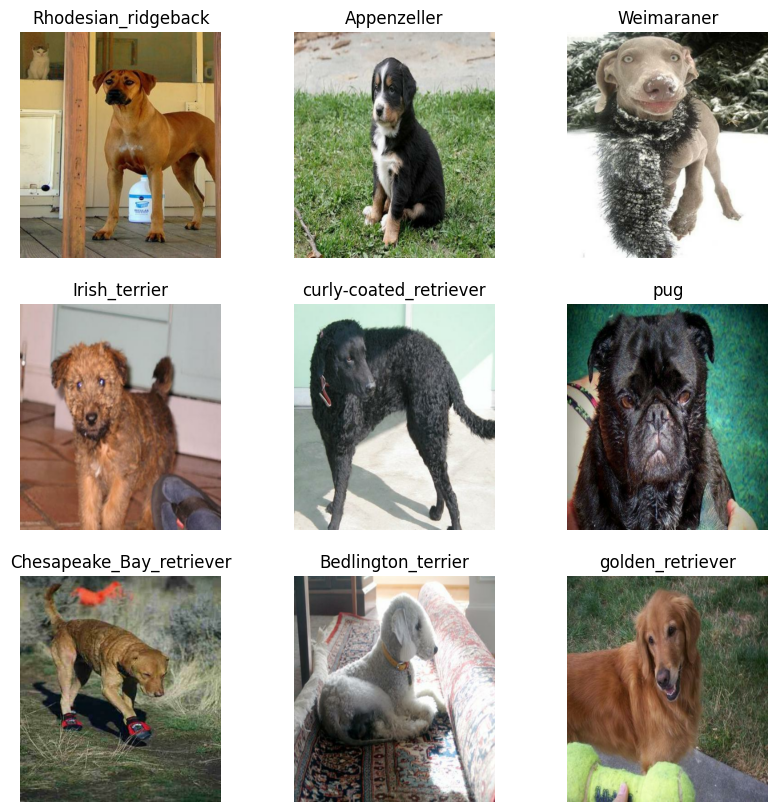

In [107]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure dataset for improved performance

'Buffered prefetching' is used to load images from disk, thus avoiding I/O blocking.

In [108]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Augment Images

As the dataset is relatively small, data augmentation is used to increase the number of training examples. This is done by applying random transformations to the images, such as flipping, rotating, and zooming. Note: vertical flipping is not used as it would not produce realistic augmentations.

These layers are only using during model training using model.fit, and are inactive during model.predict and model-evaluate etc.

In [109]:
image_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

The cell below can be run to show examples of these augmentations on the same image.

2024-06-18 08:16:50.227419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


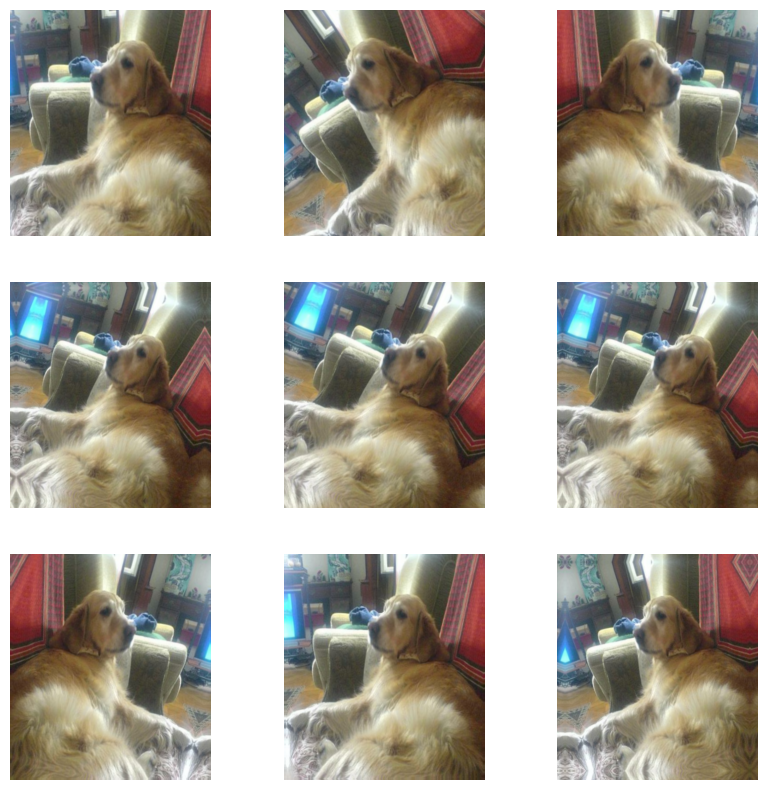

In [110]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = image_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

The following two cells will download the MobileNetV2 model and preprocess the data for the model. This model expects pixel values between -1 and 1, so we need to scale the pixel values using a Rescaling layer.

In [111]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [112]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create base model from pre-trained model MobileNetV2

In [113]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

/var/folders/31/b83g6pvj6517llc9rc703ygm0000gn/T/ipykernel_97300/603096197.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


In [114]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 14, 13, 1280)


Freeze the convolutional base

In [115]:
base_model.trainable = False

In [116]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 440, 390,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 220, 195,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 220, 195,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 220, 195,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 220, 195,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 220, 195,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 220, 195,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 220, 195,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 220, 195,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 220, 195,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 220, 195,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 220, 195,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 221, 197,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 110, 98,   │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 110, 98,   │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 110, 98,   │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 110, 98,   │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [117]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [118]:
prediction_layer = tf.keras.layers.Dense(120, activation='softmax') # 120 breeds, softmax for multi-class classification
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [119]:
image_shape = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=image_shape) # changed for our pre-loaded image_shape
x = image_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [120]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 440, 390, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 440, 390, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 440, 390, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 440, 390, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 14, 13, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [121]:
len(model.trainable_variables)

2

python(12707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


python(12714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


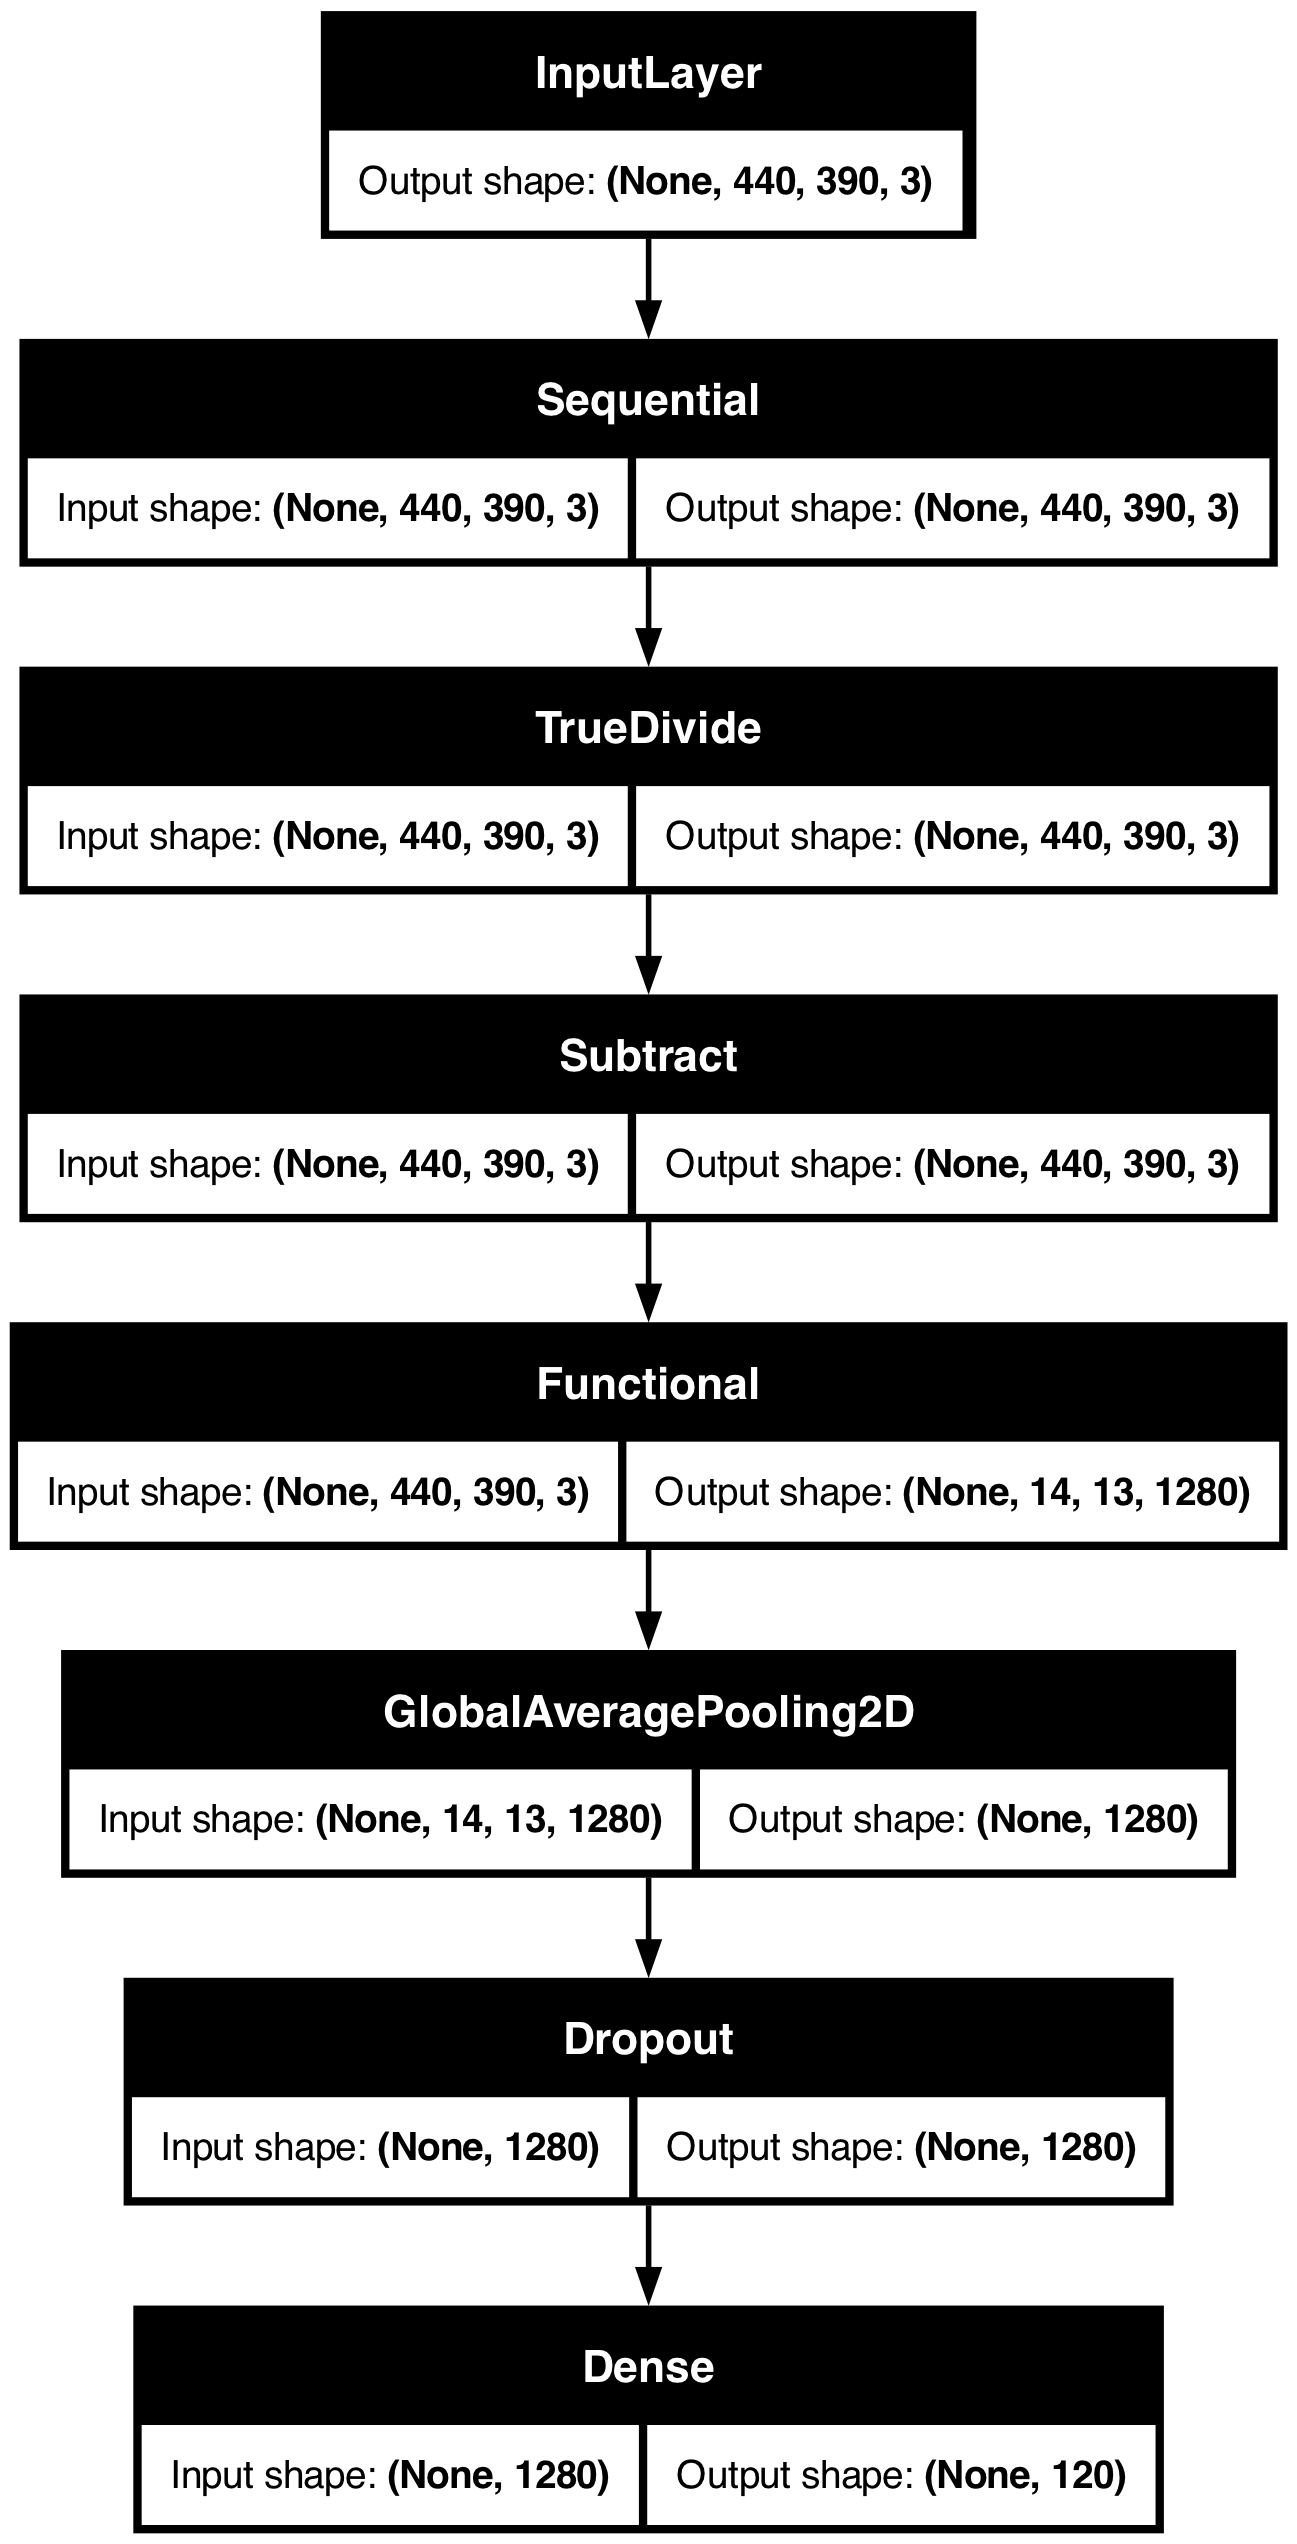

In [122]:
%pip install pydot

tf.keras.utils.plot_model(model, show_shapes=True)

Compile the model

In [123]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(), # changed from BinaryCrossentropy
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]) # Changed from BinaryAccuracy, threshold=0.5 removed.

One-hot encode the labels

In [124]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=120)
    return image, label

train_dataset = train_dataset.map(one_hot_encode)
validate_dataset = validate_dataset.map(one_hot_encode)

In [125]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validate_dataset)

95/95 ━━━━━━━━━━━━━━━━━━━━ 71s 731ms/step - accuracy: 0.0039 - loss: 4.8670


In [126]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.87
initial accuracy: 0.01


In [127]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validate_dataset)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.0309 - loss: 4.7080 - val_accuracy: 0.2466 - val_loss: 4.1522
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.2168 - loss: 4.0279 - val_accuracy: 0.4760 - val_loss: 3.6038
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - accuracy: 0.4022 - loss: 3.4965 - val_accuracy: 0.5914 - val_loss: 3.1465
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.5144 - loss: 3.0545 - val_accuracy: 0.6582 - val_loss: 2.7689
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.5817 - loss: 2.7035 - val_accuracy: 0.6932 - val_loss: 2.4584
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.6285 - loss: 2.4100 - val_accuracy: 0.7230 - val_loss: 2.2017
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.6638 - loss: 2.1625 - val_accuracy: 0.7398 - val_loss: 1.9898
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.6893 - loss: 1.9652 - val_accu

Review accuracy and loss plots

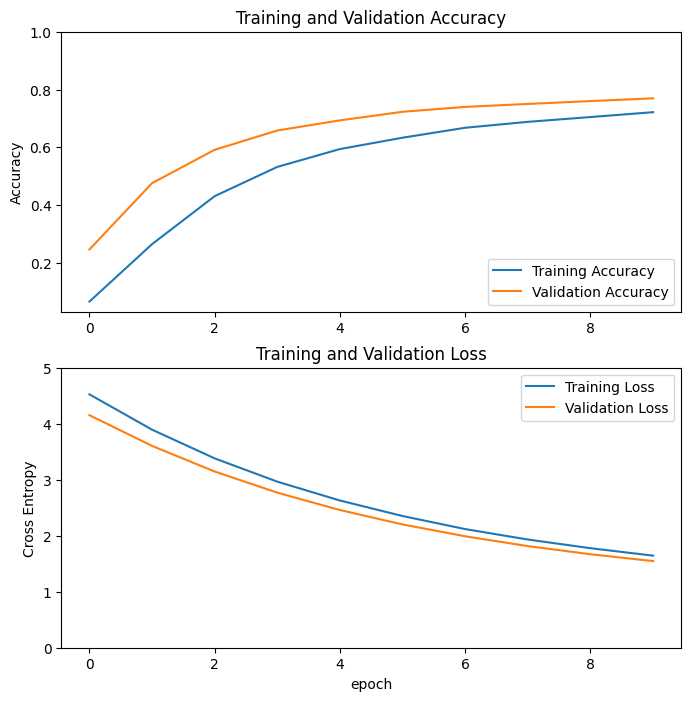

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(f'outputs/{version}/learning_curves.png')

plt.show()


Fine tuning top layers of pre-trained model

In [130]:
base_model.trainable = True

In [131]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [132]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), # changed from BinaryCrossentropy
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # try Adam if RMSprop doesn't work
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]) # Changed from BinaryAccuracy, threshold=0.5 removed.

In [133]:
len(model.trainable_variables)

56

In [134]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validate_dataset)

Epoch 11/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.6400 - loss: 1.4344 - val_accuracy: 0.7944 - val_loss: 0.8576
Epoch 12/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 1142s 3s/step - accuracy: 0.7344 - loss: 0.9740 - val_accuracy: 0.7993 - val_loss: 0.7490
Epoch 13/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 1118s 2s/step - accuracy: 0.7584 - loss: 0.8634 - val_accuracy: 0.8086 - val_loss: 0.6913
Epoch 14/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 1447s 3s/step - accuracy: 0.7668 - loss: 0.8151 - val_accuracy: 0.8096 - val_loss: 0.6611
Epoch 15/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 1086s 2s/step - accuracy: 0.7746 - loss: 0.7649 - val_accuracy: 0.8053 - val_loss: 0.6460
Epoch 16/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 1518s 3s/step - accuracy: 0.7921 - loss: 0.7291 - val_accuracy: 0.8129 - val_loss: 0.6286
Epoch 17/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 1140s 3s/step - accuracy: 0.7975 - loss: 0.6993 - val_accuracy: 0.8126 - val_loss: 0.6223
Epoch 18/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 2269s 5s/step - accuracy: 0.8040 - loss: 0.

Save model

In [167]:
model.save(f'outputs/{version}/pet-image-classifier-fine-tuned.keras')

In [136]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

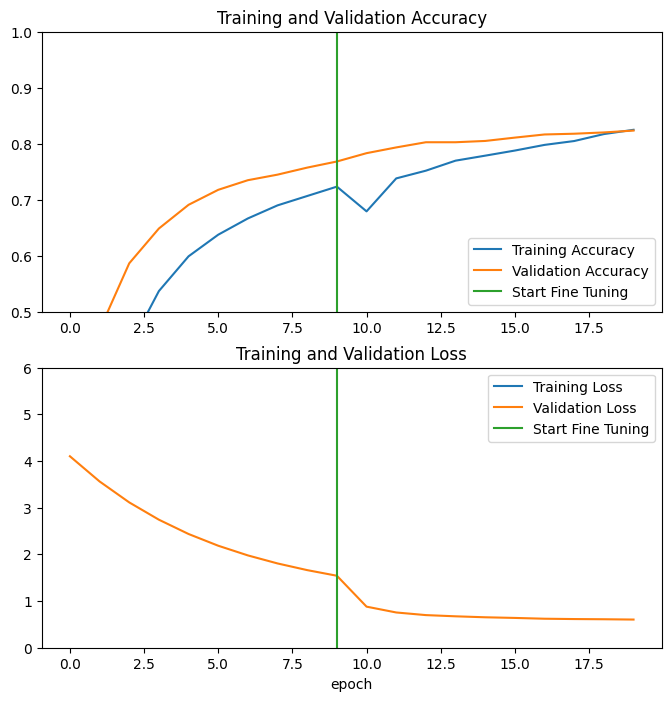

In [97]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(f'outputs/{version}/learning_curves_fine_tuned.png')

plt.show()



## Evaluate and predict

Again, we must one-hot encode the labels for the test set.

In [137]:
test_dataset = test_dataset.map(one_hot_encode)

In [138]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 760ms/step - accuracy: 0.8081 - loss: 0.5973
Test accuracy : 0.8146874904632568


Image is a Doberman. Image shape is (390, 440)


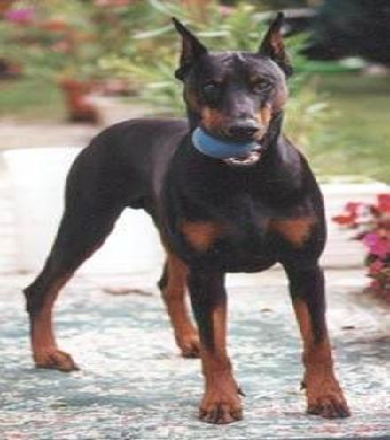

In [176]:
from tensorflow.keras.preprocessing import image

labels = os.listdir(test_dir)

pointer = 11 # Manually selected
label = labels[47] # Breed selected manually

pil_image = image.load_img(test_dir + '/'+ label + '/'+ os.listdir(test_dir+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')

print(f'Image is a {label}. Image shape is {pil_image.size}')
      
pil_image

Predict on an image from the test set shown above

In [175]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Convert the PIL image to a NumPy array and ensure it has the correct dimensions
image_array = img_to_array(pil_image.resize((440, 390)))  # resize to match model's expected input size
image_array = np.expand_dims(image_array, axis=0)

# Predict the probabilities of each class for the selected image
predictions = model.predict(image_array)

# Apply a softmax since our model returns logits
predictions = tf.nn.softmax(predictions)

# Get the top 3 predictions
values, indices = tf.nn.top_k(predictions, k=3)

# Normalize the top 3 probabilities so they sum to 1
values = values / np.sum(values)

# Get the top 3 class names and their normalized probabilities
top_3_classes = [f"{class_names[index]}: {prob:.2f}" for index, prob in zip(indices[0], values[0])]

# Print the top 3 predictions
print(f'Normalized predictions: {top_3_classes}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Normalized predictions: ['Doberman: 0.53', 'Rottweiler: 0.24', 'black-and-tan_coonhound: 0.23']


# Model Performance

Save evaluation metrics

In [168]:
joblib.dump(value=(loss, accuracy),
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v4/evaluation.pkl']